In [20]:
# ----------------------------
# CELL 1: imports / setup
# ----------------------------
import sys
import os

project_root = os.path.abspath("..")
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from config import *
from Data.raw_data_loader import load_raw_crypto_csv
from Models.zscore import zscore_signal
from Models.ou import ou_signal              # FIXED (was ou_signal_on_spread)
from Models.trend import trend_signal
from Models.mining import mining_signal
from Backtest.engine import run_backtest
from Backtest.metrics import build_summary_table, rolling_sharpe

plt.style.use("default")

In [21]:
# ----------------------------
# CELL 2: load / clean data
# ----------------------------
df = load_raw_crypto_csv(DATA_PATH, start_date=DATA_START_DATE)   # FIXED (added start_date)

df = df[(df["BTC-USD_close"] > 0)].copy()

btc_ret = df["BTC-USD_close"].pct_change()
df = df[btc_ret.abs() < 1.0]   # remove extreme data errors

print("Shape:", df.shape)
print("Start:", df.index.min(), "End:", df.index.max())

Shape: (3019, 12)
Start: 2017-11-02 00:00:00 End: 2026-02-09 00:00:00


In [ ]:
# ----------------------------
# CELL 3: base model positions
# (include this if you don't already have these defined above)
# ----------------------------
z_pos = zscore_signal(
    df["BTC-USD_close"],
    window=ZS_WINDOW,
    entry_z=ZS_ENTRY_Z,
    exit_z=ZS_EXIT_Z,
    long_short=ZS_LONG_SHORT,
).shift(1).fillna(0.0)

ou_pos = ou_signal(                            # FIXED (function + long_short)
    df["BTC-USD_close"],
    window=OU_WINDOW,
    entry_z=OU_ENTRY_Z,
    exit_z=OU_EXIT_Z,
    long_short=OU_LONG_SHORT,
).shift(1).fillna(0.0)

trend_pos = trend_signal(
    df["BTC-USD_close"],
    window=TREND_WINDOW,
    long_short=TREND_LONG_SHORT,
).shift(1).fillna(0.0)

mining_pos = mining_signal(
    df,
    long_short=MINING_LONG_SHORT,
).shift(1).fillna(0.0)

In [24]:
# ----------------------------
# CELL 4: stochastic tactical + combos
# ----------------------------
btc_buy_hold_pos = pd.Series(1.0, index=df.index, dtype=float)

def clip_pos(pos: pd.Series) -> pd.Series:
    return pos.clip(-LEVERAGE_CAP, LEVERAGE_CAP)

# BTC stochastic-style tactical model
def btc_stochastic_tactical_signal(df: pd.DataFrame) -> pd.Series:
    price = df["BTC-USD_close"].astype(float)
    cost = df["COST_TO_MINE"].replace(0.0, np.nan).astype(float)

    valuation_ratio = price / cost
    log_price = np.log(price.replace(0.0, np.nan))
    ou_z = (log_price - log_price.rolling(90).mean()) / log_price.rolling(90).std()

    ma_200 = price.rolling(200).mean()
    regime_trend = (price > ma_200).astype(float)

    signal = pd.Series(0.0, index=df.index, dtype=float)
    signal.loc[valuation_ratio < 1.05] = 1.0
    signal.loc[(regime_trend == 0.0) & (ou_z < -1.5)] = 1.0
    signal.loc[(regime_trend == 1.0) & (ou_z > -0.5)] = 1.0
    signal.loc[(ou_z > 2.0) & (valuation_ratio > 2.0)] = 0.0

    return signal.shift(1).fillna(0.0)

stochastic_pos = btc_stochastic_tactical_signal(df)

# combos
z_ou_pos = clip_pos(0.00 * z_pos + 0.40 * ou_pos + 0.60 * stochastic_pos)
ou_trend_pos = clip_pos(0.20 * ou_pos + 0.40 * trend_pos + 0.75 * stochastic_pos)
all_models_pos = clip_pos(0.60 * z_pos + 0.00 * ou_pos + 0.00 * trend_pos + 0.80 * stochastic_pos)

In [25]:
# ----------------------------
# CELL 5: run backtests
# ----------------------------
buy_hold_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=btc_buy_hold_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

stochastic_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=stochastic_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

z_ou_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=z_ou_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

ou_trend_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=ou_trend_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

all_models_results = run_backtest(
    price_series=df["BTC-USD_close"],
    position=all_models_pos,
    fee_bps=FEE_BPS,
    slippage_bps=SLIPPAGE_BPS,
    leverage_cap=LEVERAGE_CAP,
)

In [26]:
# ----------------------------
# CELL 6: summary table  (FIXED brackets)
# ----------------------------
summary = build_summary_table({
    "BTC Buy & Hold": {
        "returns": buy_hold_results["net_returns"],
        "position": btc_buy_hold_pos,
    },
    "Stochastic Tactical": {
        "returns": stochastic_results["net_returns"],
        "position": stochastic_pos,
    },
    "Z-Score + OU": {
        "returns": z_ou_results["net_returns"],
        "position": z_ou_pos,
    },
    "OU + Trend": {
        "returns": ou_trend_results["net_returns"],
        "position": ou_trend_pos,
    },
    "Grand Combo (All Models)": {
        "returns": all_models_results["net_returns"],
        "position": all_models_pos,
    },
})

summary

,Sharpe,Sortino,CAGR,MaxDD,Calmar,AnnualReturn,AnnualVol,Observations,AnnualTurnover
Strategy,,,,,,,,,
BTC Buy & Hold,0.753704,1.020556,0.320936,-0.833990,0.384820,0.502618,0.666864,3019,0.000000
Stochastic Tactical,1.161993,1.406231,0.624292,-0.542021,1.151784,0.637798,0.548883,3019,16.563432
Z-Score + OU,1.018379,1.336057,0.508152,-0.640032,0.793948,0.569022,0.558753,3019,9.986419
OU + Trend,1.032883,1.378633,0.635943,-0.759227,0.837619,0.805364,0.779724,3019,13.128635
Grand Combo (All Models),1.235694,1.587299,0.616672,-0.525728,1.172987,0.600435,0.485909,3019,17.734328


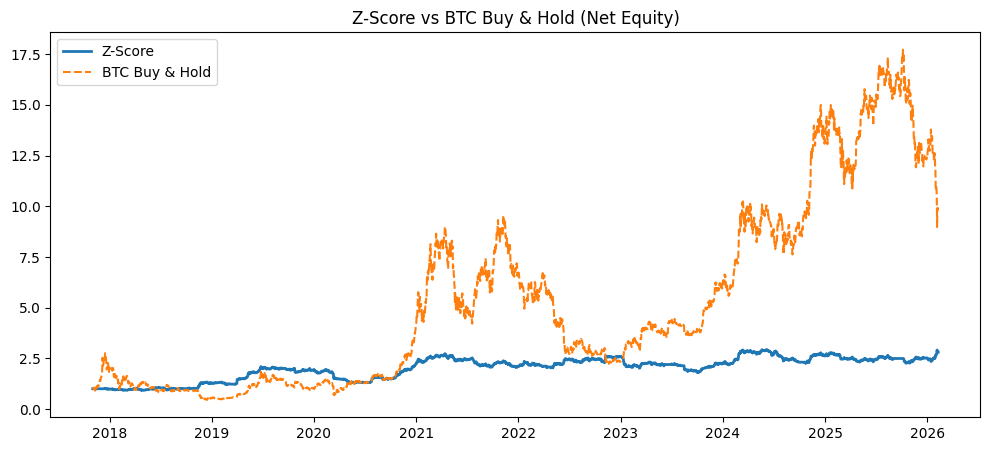

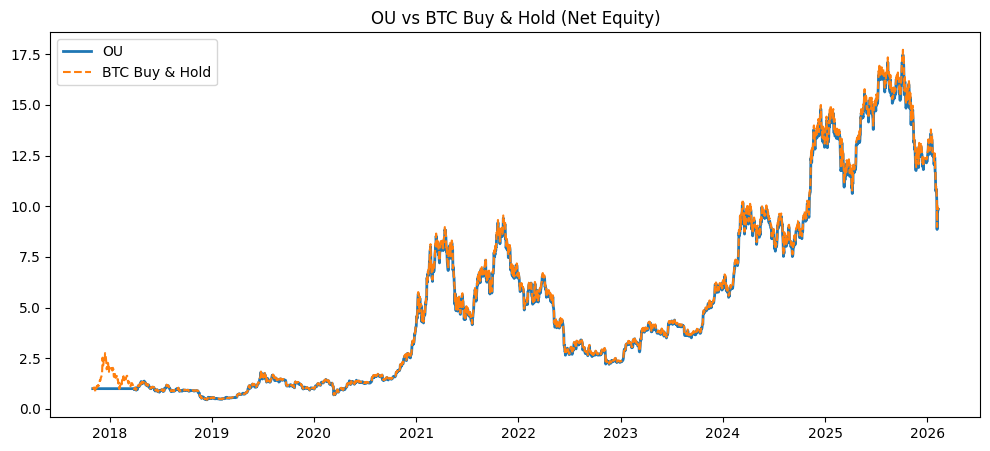

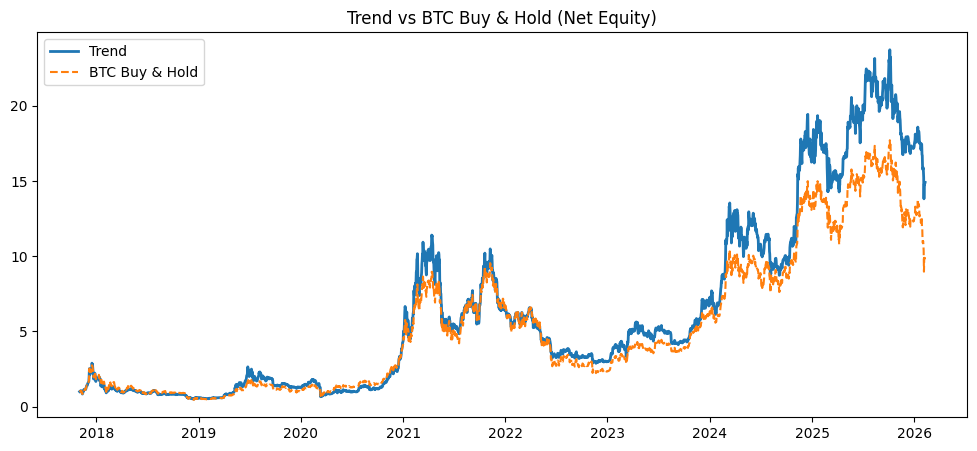

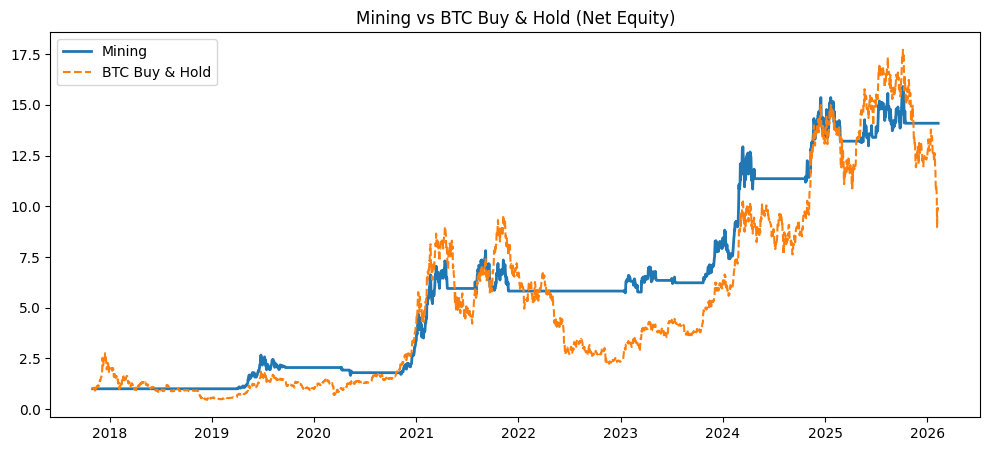

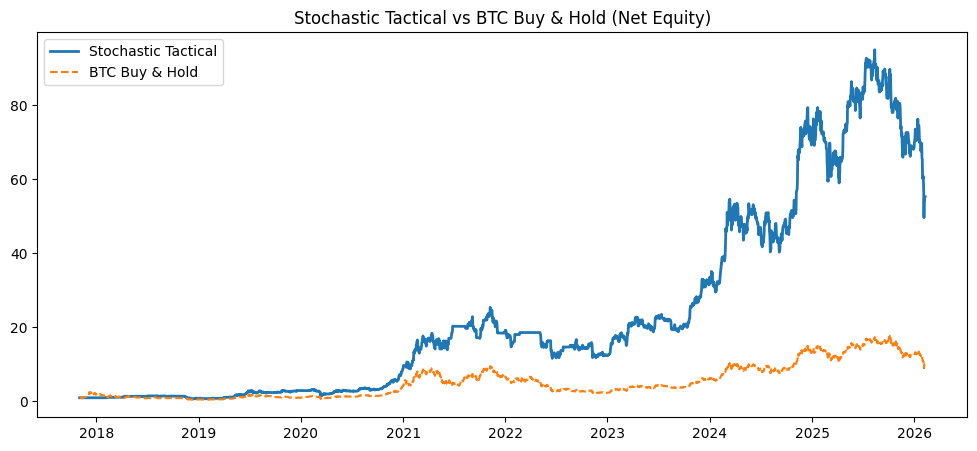

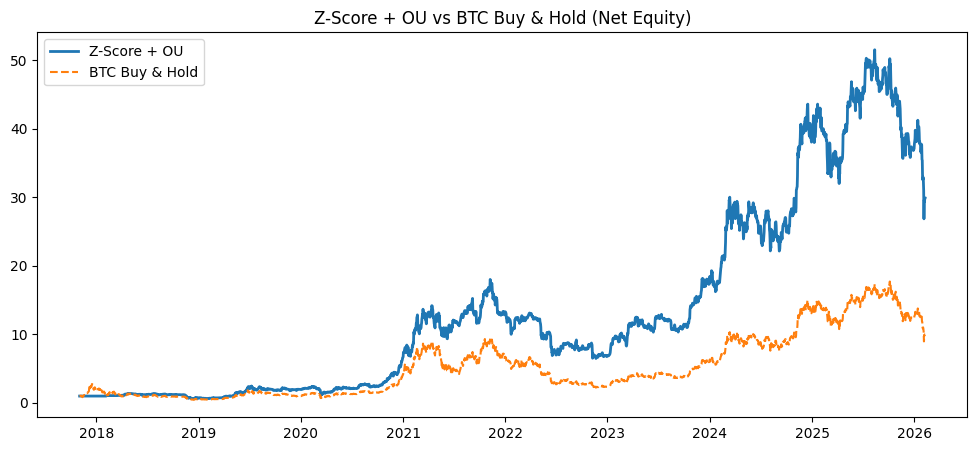

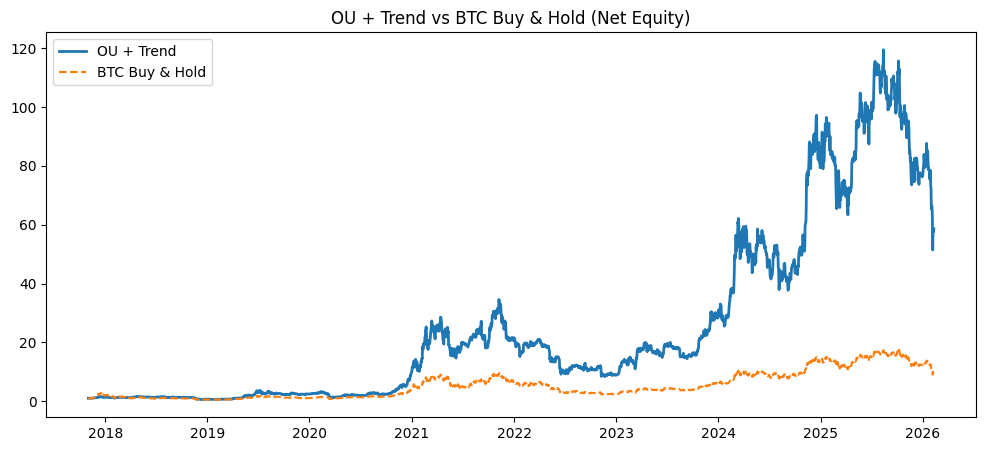

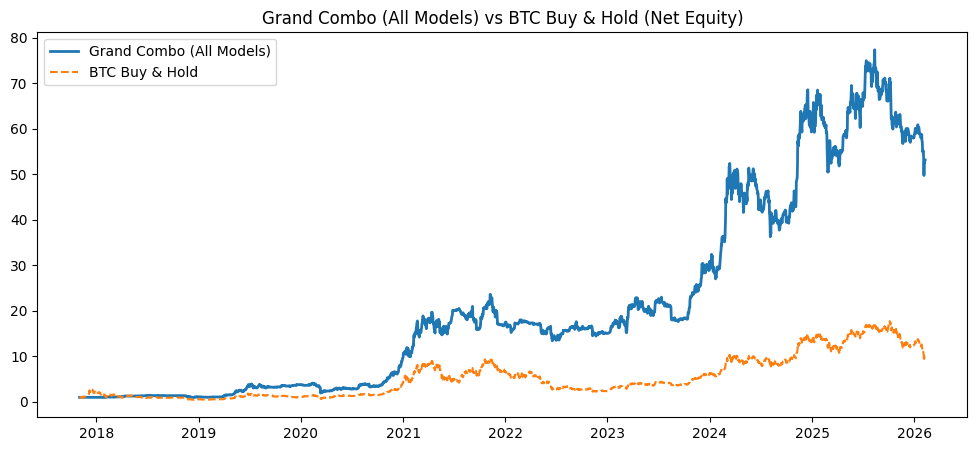

In [27]:
# ----------------------------
# CELL 7: equity plots (clean standalone cell)
# NOTE: requires z_results/ou_results/trend_results/mining_results to exist.
# If you don't have those, delete those keys.
# ----------------------------
strategy_equity = {
    "Z-Score": z_results["net_equity"],
    "OU": ou_results["net_equity"],
    "Trend": trend_results["net_equity"],
    "Mining": mining_results["net_equity"],

    "Stochastic Tactical": stochastic_results["net_equity"],
    "Z-Score + OU": z_ou_results["net_equity"],
    "OU + Trend": ou_trend_results["net_equity"],
    "Grand Combo (All Models)": all_models_results["net_equity"],
}

for name, eq in strategy_equity.items():
    plt.figure(figsize=(12, 5))
    plt.plot(eq, label=name, linewidth=2.0)
    plt.plot(buy_hold_results["net_equity"], label="BTC Buy & Hold", linestyle="--")
    plt.title(f"{name} vs BTC Buy & Hold (Net Equity)")
    plt.legend()
    plt.show()

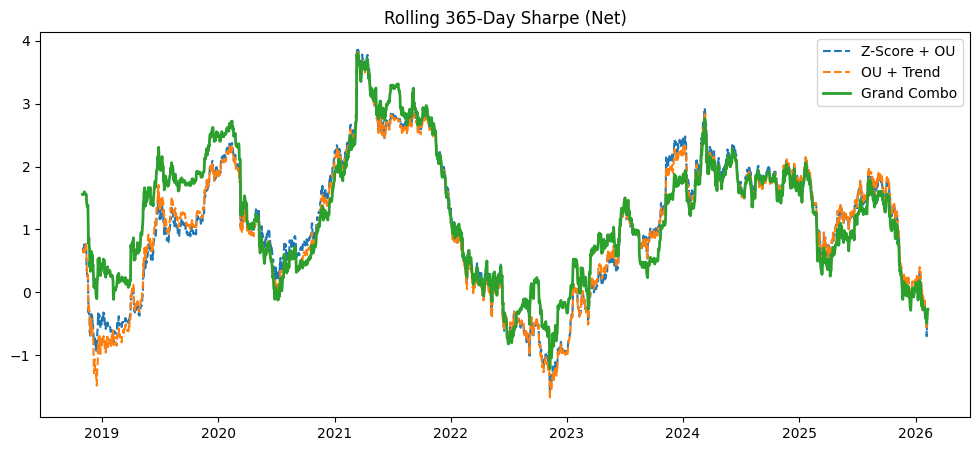

In [28]:
# ----------------------------
# CELL 8: rolling sharpe plot (FIXED extra plt.show)
# ----------------------------
plt.figure(figsize=(12, 5))
plt.plot(rolling_sharpe(z_ou_results["net_returns"], window=365), label="Z-Score + OU", linestyle="--")
plt.plot(rolling_sharpe(ou_trend_results["net_returns"], window=365), label="OU + Trend", linestyle="--")
plt.plot(rolling_sharpe(all_models_results["net_returns"], window=365), label="Grand Combo", linewidth=2.0)
plt.title("Rolling 365-Day Sharpe (Net)")
plt.legend()
plt.show()

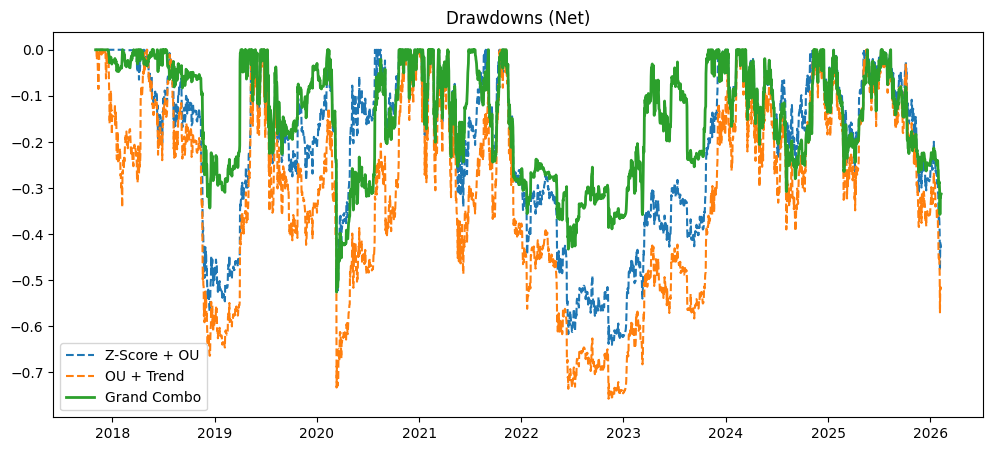

In [29]:
# ----------------------------
# CELL 9: drawdowns (FIXED extra plt.show)
# NOTE: requires drawdown() to be defined/imported in your notebook.
# ----------------------------
plt.figure(figsize=(12, 5))
plt.plot(drawdown(z_ou_results["net_equity"]), label="Z-Score + OU", linestyle="--")
plt.plot(drawdown(ou_trend_results["net_equity"]), label="OU + Trend", linestyle="--")
plt.plot(drawdown(all_models_results["net_equity"]), label="Grand Combo", linewidth=2.0)
plt.title("Drawdowns (Net)")
plt.legend()
plt.show()

In [30]:
# ----------------------------
# CELL 10: turnover prints (FIXED duplicate mining line)
# NOTE: requires annual_turnover() to be defined/imported.
# ----------------------------
print("Annual Turnover Buy&Hold:", annual_turnover(btc_buy_hold_pos))
print("Annual Turnover Z:", annual_turnover(z_pos))
print("Annual Turnover OU:", annual_turnover(ou_pos))
print("Annual Turnover Trend:", annual_turnover(trend_pos))
print("Annual Turnover Mining:", annual_turnover(mining_pos))
print("Annual Turnover Stochastic Tactical:", annual_turnover(stochastic_pos))
print("Annual Turnover Z+OU:", annual_turnover(z_ou_pos))
print("Annual Turnover OU+Trend:", annual_turnover(ou_trend_pos))
print("Annual Turnover Grand Combo:", annual_turnover(all_models_pos))

Annual Turnover Buy&Hold: 0.0
Annual Turnover Z: 7.730355231122843
Annual Turnover OU: 0.1209009605829745
Annual Turnover Trend: 1.8497846969195102
Annual Turnover Mining: 4.110632659821133
Annual Turnover Stochastic Tactical: 16.563431599867506
Annual Turnover Z+OU: 9.986419344153692
Annual Turnover OU+Trend: 13.1286353097052
Annual Turnover Grand Combo: 17.73432818689841


In [31]:
# ----------------------------
# CELL 11: alpha diagnostics (as-is, but clean cell)
# ----------------------------
def alpha_diagnostics(strategy_returns: pd.Series, benchmark_returns: pd.Series) -> dict:
    aligned = pd.concat([strategy_returns, benchmark_returns], axis=1).dropna()
    aligned.columns = ["strategy", "benchmark"]

    excess = aligned["strategy"] - aligned["benchmark"]
    alpha_ann = float(excess.mean() * 365)
    info_ratio = float((excess.mean() / excess.std(ddof=1)) * np.sqrt(365)) if excess.std(ddof=1) > 0 else np.nan

    return {
        "Alpha_Annualized": alpha_ann,
        "InformationRatio": info_ratio,
    }

combo_alpha = pd.DataFrame({
    "Z-Score + OU": alpha_diagnostics(z_ou_results["net_returns"], buy_hold_results["net_returns"]),
    "OU + Trend": alpha_diagnostics(ou_trend_results["net_returns"], buy_hold_results["net_returns"]),
    "Grand Combo (All Models)": alpha_diagnostics(all_models_results["net_returns"], buy_hold_results["net_returns"]),
}).T

combo_alpha

,Alpha_Annualized,InformationRatio
Z-Score + OU,0.066404,0.214309
OU + Trend,0.302746,1.026874
Grand Combo (All Models),0.097816,0.231951
